In [2]:
import sklearn.datasets
import urllib.request
from typing import Callable

import numpy as np
from proxskip.types import ProximityOperator, Vector, Function, Session
from proxskip.algorithm import Algorithm

In [3]:
w8a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"

data_path = './w8a'
f = urllib.request.urlretrieve(w8a_url, data_path)
# f = urllib.request.urlretrieve(a9a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

In [4]:
A.shape, b.shape

((49749, 300), (49749,))

In [7]:
norm_sum_ = np.zeros_like(*A.shape[1:], dtype=np.float32)
for i in range(A.shape[0]):
    norm_sum_ += np.linalg.norm(A[i].toarray()) ** 2
norm_sum = norm_sum_ / A.shape[0] / 4
norm_sum

2.9125510060503728

In [8]:
class DistrubutedLogisticRegression(Function):
    def __init__(self, X, y, lambda_: float, num_devices: int):
        self.X = X
        self.y = y
        self.lambda_ = lambda_
        self.n, self.d = X.shape
        self.num_devices = num_devices
        
        self.Xs = np.split(self.X, self.num_devices)
        self.ys = np.split(self.y, self.num_devices)
        self.ns = [X.shape[0] for X in self.Xs]
        self.ds = [X.shape[1] for X in self.Xs]
        
        self.L = []
        for device in range(self.num_devices):
            sum_ = np.zeros_like(self.Xs[device].shape[1:], dtype=np.float32)
            for i in range(self.ns[device]):
                sum_ += np.linalg.norm(self.Xs[device][i].toarray()) ** 2
            self.L.append(sum_ / self.ns[device] / 4)
            
        self.L = np.array(self.L)
            
        self.ws = []
    

In [9]:
class L1Norm(ProximityOperator):
    def __call__(
        self, 
        x: Vector, 
        gamma: Vector = None, 
        ksi: Callable[[Vector], Vector] = None
    ):
        u = np.full_like(x, -gamma + 2 * np.random.rand() * gamma)
        u[x > gamma] = x[x > gamma] - gamma
        u[x < -gamma] = x[x < -gamma] + gamma
        

In [10]:

fn = DistrubutedLogisticRegression(A, b, 1000 / norm_sum_)
prox = L1Norm()
al = Algorithm(
    fn,
    prox
)

al.new_session(
    Session(
        num_iterations=100000,
        step_size=0.0001,
        probability=1/100,
        x0=np.random.randn(20),
        h0=np.random.randn(20)
    )
)

losses = []
while (x := al.step()):
    al.update(*x)
    losses.append(((al._parameters * fn.X - fn.y) ** 2).mean())

ValueError: dimension mismatch

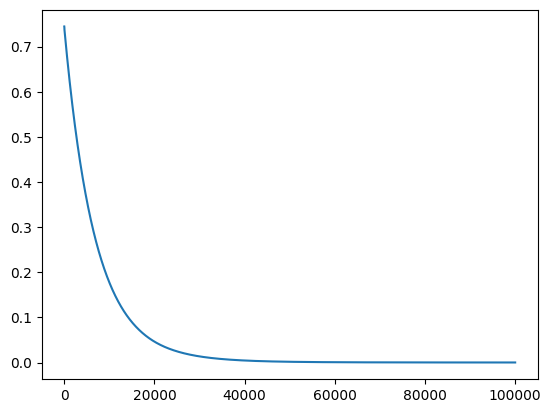

In [2]:
import matplotlib.pyplot as plt


plt.plot(MSE)

In [4]:
al._parameters, fn.alpha_

(array([0.52464954, 0.51333363, 0.52782926, 0.48370492, 0.52310412,
        0.5162634 , 0.52320396, 0.49070126, 0.52360092, 0.50922853,
        0.52354134, 0.52177013, 0.52103939, 0.5199353 , 0.52080733,
        0.51778024, 0.52179499, 0.5238046 , 0.52350281, 0.52397459]),
 0.5358033945403634)

In [47]:
from typing import Callable

import numpy as np
from proxskip.data import DataLoader
from proxskip.types import ProximityOperator, Vector
from proxskip.model import Model
from proxskip.loss import LossFunction
from proxskip.optimizer import ProxSkip

np.random.seed(705)

class ConsesusProx(ProximityOperator):
    def __call__(
        self,
        x: Vector,
        state: dict
    ):
        x_h_tp1 = state['x_h_tp1']
        avg_weight = np.zeros(shape=x_h_tp1[0].shape)

        for local_weight in x_h_tp1: 
            avg_weight += local_weight

        avg_weight /= len(x_h_tp1)
        return avg_weight


class Linear(Model):
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self._W = np.random.randn(in_features, out_features)
        print(self._W.std(), self._W.mean())
        # self._b = np.random.randn(out_features)

    def params(self) -> Vector:
        # return np.concatenate([self._W.ravel(), self._b.ravel()])
        return self._W

    def forward(self, x: Vector) -> Vector:
        # the assumption here is that 
        if x.ndim > 2: 
            raise ValueError(f"Please make sure the input is 2 dimensionsal. Found: {x.ndim} dimensions")        

        batch_size, features = x.shape
        if features != self.in_features: 
            raise ValueError(f"The input is expected to have: {self.in_features} features")

        output = x @ self._W

        assert output.shape == (batch_size, self.out_features), \
            f"Make sure the output is of the correct shape. Found: {batch_size, self.out_features}. "\
            "Found: {x.shape}"
        return output

    
    def backward(self, x: Vector, upstream: Vector) -> Vector:
        output = self.forward(x)
        # make sure the upstream grad is of the exact same shape
        assert upstream.shape == output.shape, f"Make sure the upstream gradient has the same as the output of the forward pass. Found: {upstream.shape}, Expected: {output.shape}"
        
        # calculate 'grad'
        grad = x.T @ upstream
        # make sure the grad is of the exact same shape as the weights  
        assert grad.shape == self._W.shape, f"Make sure the shape of the grad is the same as the weights. Found: {grad.shape}. Expected: {self._W.shape}"

        return grad


    def update(self, params: Vector) -> None:
        # self._W = params[:self._W.size].reshape(self._W.shape)
        # self._b = params[self._W.size:]
        self._W = params.copy()

class SimpleDataset(DataLoader):
    def __init__(self, X, y, batch_size) -> None:
        self._X = X
        self._y = y
        self._batch_size = batch_size
        self._n = (X.shape[0] + batch_size - 1) // batch_size

    def total_size(self) -> int:
        return self._X.shape[0]

    def get(self) -> tuple[Vector, Vector]:
        i = np.random.randint(0, self._n)
        return self._X[i * self._batch_size:(i + 1) * self._batch_size], self._y[i * self._batch_size:(i + 1) * self._batch_size]
    

class MSE(LossFunction):
    # def dloss(self, j: int, size: int) -> Vector:
    #     """Gradient of MSE loss function w.r.t. model parameters"""
    #     # extract the data and the labels
    #     X, y = self._dl.get(j, size)
    #     # forward pass: predict
    #     y_hat = self._M.forward(X)

    #     # MSE LOSS will be defined as the average of the squared error between y_hat and y
    #     # so the gradient with respect to each element in 'y_hat' is the difference between y_hat_i and y_i divided by the number of elements in 'y' 
    #     mse_loss_grad = (y_hat - y) / y.size
    #     # why mean ???
    #     return self._M.backward(X, mse_loss_grad)# .mean(axis=0) 
        
    # def loss(self, j: int, size: int) -> float:
    #     """MSE loss function"""
    #     X, y = self._dl.get(j, size)
    #     y_hat = self._M.forward(X)
    #     return ((y_hat - y) ** 2).mean()
    
    def upstream_gradient(self, y: Vector, y_hat: Vector) -> float:
        return (y_hat - y) / y.size
    
    def loss(self, m: Model, X: Vector, y: Vector) -> Vector:
        y_hat = m.forward(X)
        return ((y_hat - y) ** 2).mean()
        
    
    
    
    
X = np.random.randn(20, 10)
y = X @ np.random.randn(10, 1)
    
devices = [
    (Linear(10, 1), SimpleDataset(X[:10], y[:10], 5)),
    (Linear(10, 1), SimpleDataset(X[10:], y[10:], 5)),
]
    
optimizer = ProxSkip(
    models=[model for model, _ in devices],
    dataloaders=[dataloader for _, dataloader in devices],
    loss=MSE,
    prox=ConsesusProx(),
    num_iterations=100000,
    learning_rate=1E-3,
    batch_size=100,
    p=.1,
)

while optimizer._step['t'] < 10000:
    on_prox = optimizer.step()
    if on_prox is None:
        break
    if on_prox:
        print(optimizer._step['loss'][-1])

0.5521678813024953 -0.6564956044391757
0.887357490394384 -0.40833101024192464
55.85735915804341
32.37980554512224
72.09432561846693
32.16784433885915
71.75147587301817
31.752438649695076
70.63737920178761
68.97968446012786
29.817065314012822
29.500299944768006
45.587608559135546
29.874583866058654
50.18550737559055
50.08944207312445
44.89926268670658
29.408338782789933
64.65550944061174
49.73634570717687
64.20174755747196
64.07099646999929
48.80542549247207
43.82990636315954
63.278738498889716
48.11534229059776
47.953267404572514
28.247189531604946
46.329493329287224
41.22738062209068
41.01347513857581
27.41724400325636
45.371086360445375
45.56822206982259
58.67435011724254
44.5381370811692
44.83885526353783
44.76402258678678
57.493462071223874
57.83371624600019
44.96542323572913
27.653395183808158
44.42171316291481
27.452331119046406
42.72704067925416
26.333978078241266
41.93831694631341
54.214125966937644
37.81773863389092
41.242721585033976
26.144206293707967
26.285713827867045
38.1

In [48]:
np.max(optimizer._step['loss']), np.min(optimizer._step['loss'])

(72.09432561846693, 7.29628822485455)

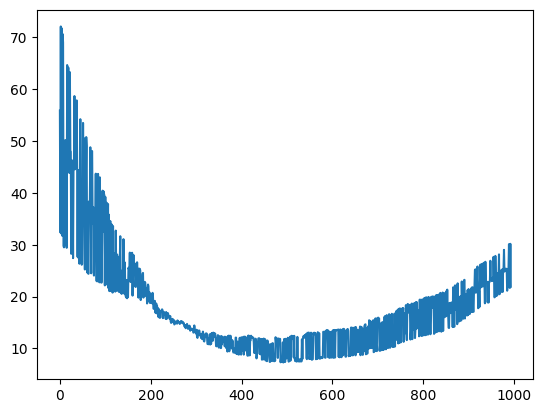

In [49]:
import matplotlib.pyplot as plt

plt.plot(optimizer._step['loss'])